In [1]:
from funciones import*
import pandas as pd
import matplotlib.pyplot as plt


Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')
#file3=import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/develop_1/data/Time_series_DATA.txt')
#Data=pd.read_csv(file3,skiprows=149,index_col=0)
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39309 entries, 1901-02-01 to 2024-02-06
Data columns (total 24 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Nenana: Rainfall [mm]                              29547 non-null  float64
 4   Nenana: Snowfall [mm]                              19945 non-null  float64
 5   Nenana: Snow depth [mm]                            15984 non-null  float64
 6   Nenana: Mean water temperature [C]                 2418 non-null   float64
 7   Nenana: Mean Discharge [m3/s]                      22562 non-null  float64
 8   Nenana: Air temperature [C]                        31171 non-null  fl

# 2.3 Ice growth [Temperature-based prediction]
Ashton's formula to predict the ice growth is an improved version of Stefan's formula [[1]](https://static1.1.sqspcdn.com/static/f/572109/18056158/1336339358653/thin+ice+growth.pdf?token=9mlCTJ8q6DFV3imaaSj54iHJW%2FQ%3D))

$$\frac{dH}{dt}=\left(\frac{1}{\rho L}\right)\frac{T_m-T_a}{\frac{h}{k}+\frac{1}{H_{ia}}}$$

First, lets assume reasonable values for the constants, predict the ice growth and compare it with the measurements.

 (all value from Wolfram Alpha knowledge database)
- Ice density - $\rho=997.048 [kg/m^3] $
- Ice heat of fusion(specific) -  $L=334000 [J/kg]$
- Ice fusion temperature - $T_m=0[°C]$
- Ice thermal conductivity - $k=0.598 [W/(m °C)]$
- Heat transfer coeficient -$H_{ia}=20 [W/(m^2 °C)]$

Variables
- t[s]
- h[m]


## Assumptions
- The ice thickness is set to zero  for days (150-250) of each year
- The temperature is constant throughout the day
- Freezing temperature of water= Tm ( currently -5)

In [2]:
def solve_ODE(df,
              ODE=dict)->pd.DataFrame:
    '''
    Solves and ODE of order 1 associated with timeseries

    Parameters
    ----------
    ODE:dict
        Dictionary with parameers
     
    '''


In [3]:
cutoff_0=150
cutoff_1=305
# defining constants
rho = 997.048
L = 334000
Tm = -5
k = 0.598
Hia = 30


# Loading Data
Method_0 = pd.DataFrame(0, index=Data.index, columns=['Predicted thickness [m]'])
Method_0['Regional: Air temperature [C]']=Data['Regional: Air temperature [C]']
Method_0['Days until break up']=Data['Days until break up']
# Initializing df
# Method_0: no modifications
# Method_1: ice thickness after break_up is zero
# Method_2: ice thicknessafter break_up is zero, the ice melts faster than what it grows
Method_0=Method_0.dropna()
Method_0.index=pd.to_datetime(Method_0.index)
Method_1=Method_0.copy()
Method_2=Method_0.copy()


# we could execute the code in a single loop, but because the performance demand is very low, looping through years and days instead of through element in index is clearer
accelerated_melting=[5,1.3] # if temp> accelerated_melting[0],accelerated_gradient=gradient*acceletaded_melting[1]
# Year-loop
for year in Method_0.index.year.unique():
    Frozen=True
    print('+++++++++++++++++',year,'+++++++++++++++++')
    df_year_0 = Method_0[Method_0.index.year == year]
    df_year_1 = Method_1[Method_1.index.year == year]
    df_year_2 = Method_2[Method_2.index.year == year]

    if year > Method_0.index.year.min():
        # Get the ice thickness from December 31st f the previous year
        thickness_last_year_0= Method_0.loc[Method_0.index.year == year - 1, 'Predicted ice thickness [m]'].iloc[-1]
        thickness_last_year_1= Method_1.loc[Method_1.index.year == year - 1, 'Predicted ice thickness [m]'].iloc[-1]
        thickness_last_year_2= Method_2.loc[Method_2.index.year == year - 1, 'Predicted ice thickness [m]'].iloc[-1]
        # Set the ice thickness for January 1st of the current year to be the same as December 31st of the previous year
        df_year_0.loc[df_year_0.index.dayofyear == 1, 'Predicted ice thickness [m]'] = thickness_last_year_0
        df_year_1.loc[df_year_1.index.dayofyear == 1, 'Predicted ice thickness [m]'] = thickness_last_year_1
        df_year_2.loc[df_year_2.index.dayofyear == 1, 'Predicted ice thickness [m]'] = thickness_last_year_2
        
    else: # for the first year set January 1st thickness to 0.8   The result if full melting happens(has always happened) should not depend on this 
        df_year_0.loc[df_year_0.index.dayofyear == 1, 'Predicted ice thickness [m]'] = 0.8
        df_year_1.loc[df_year_1.index.dayofyear == 1, 'Predicted ice thickness [m]'] = 0.8
        df_year_2.loc[df_year_2.index.dayofyear == 1, 'Predicted ice thickness [m]'] = 0.8
# loop days
    for i in range(1, len(df_year_0)):
        H_prev = df_year_0.at[df_year_0.index[i - 1], 'Predicted ice thickness [m]']
        T_current = df_year_0.at[df_year_0.index[i], 'Regional: Air temperature [C]']
        delta_H = (1) / (rho * L) * (Tm - T_current) / (H_prev / k + 1 / Hia)
        Predicted_H = (H_prev + delta_H * 86400)*1  # seconds in a day
        if T_current>C1[0]: # accelerated melting in high temperature
          delta_H_2 = delta_H*C1
        elif T_current<=C2[0]: # we assume that when the air temperature is below zero, the water temp is 5 degree colder
          delta_H = (1) / (rho * L) * (Tm - (T_current-C2[1])) / (H_prev / k + 1 / Hia)*C2[2]
        else:
          delta_H = (1) / (rho * L) * (Tm - T_current) / (H_prev / k + 1 / Hia)

        
        #print(Predicted_H)
        # here we force zero thickness in summer
        if cutoff_0 <= df_year.index[i].dayofyear <= cutoff_1:  # here this should be a list witht hr day_oy_year of the break up file
            Predicted_H = 0
        if Predicted_H <= 0:
            Predicted_H = 0
        df_year.at[df_year.index[i], 'Predicted ice thickness [m]'] = Predicted_H
    Method_1.loc[df_year.index, 'Predicted ice thickness [m]'] = df_year['Predicted ice thickness [m]']


C:\Users\gabri\AppData\Local\Temp\ipykernel_18400\454168789.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year.loc[df_year.index.dayofyear == 1, 'Predicted ice thickness [m]'] = 0.8



- Freezing temperature of water= Tm ( currently -5)
- The temperature is constant throughout the day

In [4]:
C1=[5,5,5] # accelerated melting (temp) , when T>C1[0]->T=T+C1[1] and gradient=gradient*C1[2]
C2=[0,5,1.5] # accelerated freezing (temp), when T<C2[0]->T=T-C2[1] and gradient=gradient*C2[2]

# Year-loop
Method_1_1=Method_1.copy()
for year in Method_1_1.index.year.unique():
    print('+++++++++++++++++',year,'+++++++++++++++++')
    # Varibale to see global state
    Frozen=True
    df_year = Method_1_1[Method_1_1.index.year == year].copy()
    if year > Method_1_1.index.year.min():
        # Get the ice thickness from December 31st of the previous year
        thickness_last_year = Method_1_1.loc[Method_1_1.index.year == year - 1, 'Predicted ice thickness [m]'].iloc[-1]
        # Set the ice thickness for January 1st of the current year to be the same as December 31st of the previous year
        df_year.loc[df_year.index.dayofyear == 1, 'Predicted ice thickness [m]'] = thickness_last_year
    else: # for the first year set January 1st thickness to 0.6
        df_year.loc[df_year.index.dayofyear == 1, 'Predicted ice thickness [m]'] = 0.6
# loop days
    for i in range(1, len(df_year)):
        H_prev = df_year.at[df_year.index[i - 1], 'Predicted ice thickness [m]']
        T_current = df_year.at[df_year.index[i], 'Regional: Air temperature [C]']
        if T_current>C1[0]: # accelerated melting in high temperature
          delta_H = (1) / (rho * L) * (Tm - (T_current+C1[1])) / (H_prev / k + 1 / Hia)*C1[2]
        elif T_current<=C2[0]: # we assume that when the air temperature is below zero, the water temp is 5 degree colder
          delta_H = (1) / (rho * L) * (Tm - (T_current-C2[1])) / (H_prev / k + 1 / Hia)*C2[2]
        else:
          delta_H = (1) / (rho * L) * (Tm - T_current) / (H_prev / k + 1 / Hia)
        Predicted_H = (H_prev + delta_H * 86400)*1  # seconds in a day
        # here we eliminate negative thickness
        if Predicted_H <= 0:
            Predicted_H = 0
            if Frozen: # adding this so in only alerts aus the first time the ice melts
              Frozen=False
              print("Day:"+str(df_year.index.dayofyear[i]),"ice is fully melted")
        else:
            if not Frozen:
              Frozen=True
              print("Day:"+str(df_year.index.dayofyear[i]),'ice has starting to form')
        df_year.at[df_year.index[i], 'Predicted ice thickness [m]'] = Predicted_H
    Method_1_1.loc[df_year.index, 'Predicted ice thickness [m]'] = df_year['Predicted ice thickness [m]']


+++++++++++++++++ 1917 +++++++++++++++++
Day:162 ice is fully melted
Day:277 ice has starting to form
Day:279 ice is fully melted
Day:288 ice has starting to form
+++++++++++++++++ 1918 +++++++++++++++++
Day:189 ice is fully melted
Day:278 ice has starting to form
Day:280 ice is fully melted
Day:285 ice has starting to form
Day:286 ice is fully melted
Day:287 ice has starting to form
+++++++++++++++++ 1919 +++++++++++++++++
Day:169 ice is fully melted
Day:272 ice has starting to form
Day:273 ice is fully melted
Day:274 ice has starting to form
+++++++++++++++++ 1920 +++++++++++++++++
Day:181 ice is fully melted
Day:267 ice has starting to form
Day:270 ice is fully melted
Day:276 ice has starting to form
+++++++++++++++++ 1921 +++++++++++++++++
Day:173 ice is fully melted
Day:268 ice has starting to form
Day:272 ice is fully melted
Day:275 ice has starting to form
Day:280 ice is fully melted
Day:281 ice has starting to form
Day:282 ice is fully melted
Day:285 ice has starting to form
Da

### Stefan's Formula
> "*The classical Stefan Problem aims to determine how an ice layer grows as a function of time, given the constraint that air the air temperature Tair is constant, smaller h ice icethan Tfr and everywhere the same*."


### Comparison

Text(0.5, 1.0, 'Ice growth')

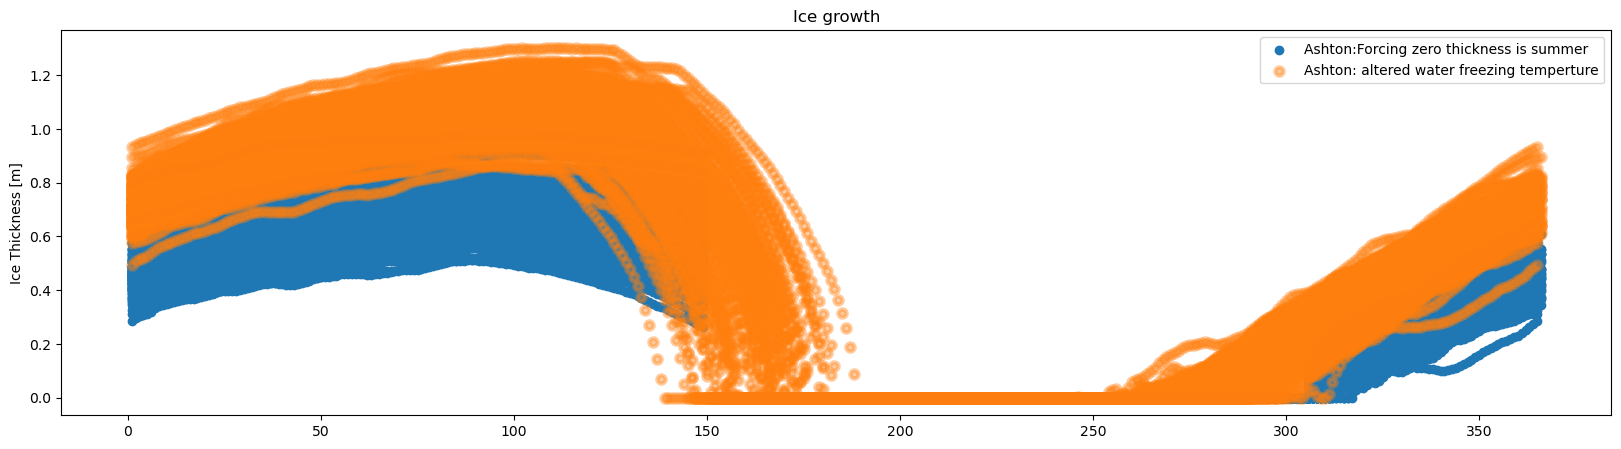

In [18]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.scatter(Method_1.index.dayofyear,Method_1['Predicted ice thickness [m]'],label='Ashton:Forcing zero thickness is summer')
ax.scatter(Method_1_1.index.dayofyear,Method_1_1['Predicted ice thickness [m]'], label='Ashton: altered water freezing temperture',alpha=0.4,linewidth=3)
ax.set_ylabel('Ice Thickness [m]')
ax.legend()
ax.set_title("Ice growth")
#ax.set_xlim(['2011-01-01','2011-06-01'])

In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from scipy.stats import norm,kstest
from matplotlib.cm import ScalarMappable
from scipy.stats import pearsonr



def standard_plot(Data,Ice):
    """
    Ice: One column with the data. We assume same length as data ( if we create ice from temperature data it should match)
    Data:Data=pd.read_csv('https://github.com/iceclassic/sandbox/blob/main/content/Time_series_DATA.txt?raw=true',index_col=0,skiprows=149)

    """
    Ice.drop(columns=['Predicted thickness [m]','Regional: Air temperature [C]','Days until break up'],inplace=True)

    # HERE WE ASSUME THAT THE ICE DATA WAS PRODUCED FROM THE TEMP DATA IN THE DF SO WE DONT WORRY ABOUT DIFFERENT LENGTHS
    # I realized cannot reall asume this cuz of NaN
    Data=pd.merge(Data,Ice,how='left',left_index=True,right_index=True)
    # Getting the df ready to plot and fit
    filtered_data = Data.dropna(subset=['Predicted ice thickness [m]', 'IceThickness [cm]']).copy()
    years = filtered_data.index.year.unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(years)))

    drop_mask = filtered_data[['Predicted ice thickness [m]', 'IceThickness [cm]']].notna().all(axis=1)

    filtered_data=filtered_data[drop_mask]

    years = filtered_data.index.year.unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(years)))
    #==========================================================================
    filtered_data['Residuals'] = filtered_data['Predicted ice thickness [m]'] * 100 - filtered_data['IceThickness [cm]']

    #
    fig, ax = plt.subplots(6, 1, figsize=(20, 35))

    plot_style={
                'Style1':{'color':'navy','alpha':0.8,'linestyle':'-'},
                'Style2':{'color':'magenta','alpha':0.8,'linestyle':'--'},
                'Cmap':{'cmap':'viridis'}}


    #----------PLOT 1----------------------------------------#

    ax[0].plot(filtered_data.index,filtered_data['Predicted ice thickness [m]']*100, **plot_style['Style1'], label='Predicted ice thickness')
    ax[0].plot(filtered_data.index,filtered_data["IceThickness [cm]"], **plot_style['Style2'], label='Measured ice thickness')
    ax[0].set_ylabel('Predicted Ice Thickness [cm]')
    ax[0].legend()
    ax[0].set_title('Predicted ice thickness')

    L2=np.sqrt(np.sum(filtered_data['Residuals'] ** 2))


    #----------PLOT 3----------------------------------------#
    sc = ax[1].scatter(filtered_data['Days until break up'], filtered_data['Predicted ice thickness [m]'] * 100, c=filtered_data.index.year,**plot_style['Cmap'],s=1)
    for i, year in enumerate(years):
        year_data = filtered_data[filtered_data.index.year == year]
        year_data_ice= filtered_data['Predicted ice thickness [m]'][filtered_data.index.year == year]
        ax[1].plot(year_data['Days until break up'], year_data_ice* 100, marker=',', color=colors[i], alpha=0.8)

    cbar = plt.colorbar(sc)
    cbar.set_label('Year')

    ax[1].scatter(filtered_data['Days until break up'], filtered_data["IceThickness [cm]"], color="magenta", alpha=0.8,label='Measured ice thickness', marker='1', s=100)
    ax[1].set_ylabel('Predicted Ice Thickness [cm]')
    ax[1].set_xlabel('Days until break up')
    ax[1].legend()
    ax[1].set_title('Predicted ice thickness, normalized to days until break up')

    #----------PLOT 3----------------------------------------#
    sc = ax[2].scatter(filtered_data['Days until break up'], filtered_data['Residuals'], c=filtered_data.index.year, cmap='viridis', alpha=0.8,s=1)
    cbar = plt.colorbar(sc)
    cbar.set_label('Year')

    for i, year in enumerate(years):
        year_data = filtered_data[filtered_data.index.year == year]
        ax[2].plot(year_data['Days until break up'], year_data['Residuals'], marker='1', color=colors[i], alpha=0.8)

    # Polynomial fit
    n_degree = 1
    coefficients, residuals, _, _, _= np.polyfit(filtered_data['Days until break up'], filtered_data['Residuals'], n_degree,full=True)
    polynomial = np.poly1d(coefficients)
    x_fit = np.linspace(-130, 0, 120)
    y_fit = polynomial(x_fit)
    ax[2].plot(x_fit, y_fit, color='k', label=f'Polynomial Fit (degree={n_degree}, L2={np.sqrt(residuals[0]):.2f})', linestyle='--', linewidth=3)

    ax[2].set_ylabel('Residuals [cm]')
    ax[2].set_xlabel('Days to break up')
    ax[2].set_title('Predicted ice thickness residuals')
    ax[2].legend()
    print(f'Prediction vs measurement, polyfit(n=1) residuals, L2={np.sqrt(residuals[0]):.2f})')


    #----------PLOT 4----------------------------------------#
    for year, color in zip(filtered_data.index.year.unique(), colors):
        year_data = filtered_data[filtered_data.index.year == year]
        ax[3].hist(year_data['Residuals'], bins=15, density=True, alpha=0.5, label=f'Year {year}', color=color)
    ax[3].set_xlabel('Residuals[cm]')
    ax[3].set_ylabel('Density')
    ax[3].set_title('Distribution of residuals per year')
    ax[3].set_xlim([-90,90])


    # Create a ScalarMappable for color mapping
    sm = ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(years), vmax=max(years)))
    sm.set_array([])  # Empty array since we just want to map colors

    # Add color bar
    cbar = plt.colorbar(sm, ax=ax[3])
    cbar.set_label('Years')


    # normal fit
    aggregated_data=filtered_data['Residuals']
    mu, std = norm.fit(aggregated_data)
    ks_statistic, p_value = kstest(aggregated_data, 'norm', args=(mu, std))
    print("================================================================================")
    print("Aggregated predicted vs measured residuals:")
    print(f'KS Statistic:{ks_statistic:.3f}')
    print(f'P-value:{p_value:.2f}')
    print(f'N ~ (\mu={mu:.2f},\sigma={std:.2f})')
    x = np.linspace(-90,90, 180)
    p = norm.pdf(x, mu, std)
    ax[4].plot(x, p, 'k', linewidth=2)
    ax[4].hist(aggregated_data, bins='auto',density=True, alpha=0.4,color='k')
    ax[4].set_xlabel('Residuals[cm]')
    ax[4].set_ylabel('Density')
    ax[4].set_title('Distribution of aggregated residuals')
    ax[4].set_xlim([-90,90])


    #----------------------SCatter plot###

    corr, _ = pearsonr(filtered_data['Days until break up'],filtered_data["IceThickness [cm]"])
    print("================================================================================")
    print("Ice thickness vs days to break up\nPearson correlation coefficient:", corr)

############### Ice thickenss at break up ( last three data points)
    # Add  break up date line
    last=[]
    last_2=[]
    for year, color in zip(filtered_data.index.year.unique(), colors):
        year_data = filtered_data[filtered_data.index.year == year]
        path_to_break_up = filtered_data[filtered_data.index.year == year].tail(5)
        last_measurement = filtered_data[filtered_data.index.year == year].tail(1)
        last.append(last_measurement['IceThickness [cm]'])
        last_2.append(last_measurement['Predicted ice thickness [m]'])
        ax[5].plot(path_to_break_up['Days until break up'],path_to_break_up['IceThickness [cm]'], color=color,linestyle='--',alpha=0.4)
        ax[5].scatter(last_measurement['Days until break up'],last_measurement['IceThickness [cm]'], color=color)

        ax[5].plot(path_to_break_up['Days until break up'],path_to_break_up['Predicted ice thickness [m]']*100, color=color,linestyle='dotted',alpha=0.4,linewidth=0.4)
        ax[5].scatter(last_measurement['Days until break up'],last_measurement['Predicted ice thickness [m]']*100, color=color,marker='x')

        year_data= year_data['Days until break up'] == 0
        #ax[7].axvline(year_data['Days since start of year'], color=color, linestyle='--')


    # Create a ScalarMappable for color mapping
    sm = ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(years), vmax=max(years)))
    sm.set_array([])  # Empty array since we just want to map colors

    # Add color bar
    cbar = plt.colorbar(sm, ax=ax[5])
    cbar.set_label('Years')
    ax[5].legend()
    ax[5].set_ylabel('IceThickness [cm]')
    ax[5].set_xlabel('Days until break up')
    ax[5].set_title('Last k-IceThickness measurements(k=5)')
    #print("Measured ice thickness before break up: ",last)
    #print("Predicted ice thickness before break up: ",last_2)
    print("============================================================")
    print("Mean IceThickness measurements before break up",np.mean(last[0]))
    print("Mean IceThickness measurements before break up",np.mean(last_2[0])*100)
    plt.show()
    Data.drop(columns=['Predicted ice thickness [m]'],inplace=True)

Prediction vs measurement, polyfit(n=1) residuals, L2=387.65)
Aggregated predicted vs measured residuals:
KS Statistic:0.059
P-value:0.08
N ~ (\mu=-0.14,\sigma=18.84)
Ice thickness vs days to break up
Pearson correlation coefficient: 0.12459312941991435


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean IceThickness measurements before break up 101.6
Mean IceThickness measurements before break up 115.483142166718


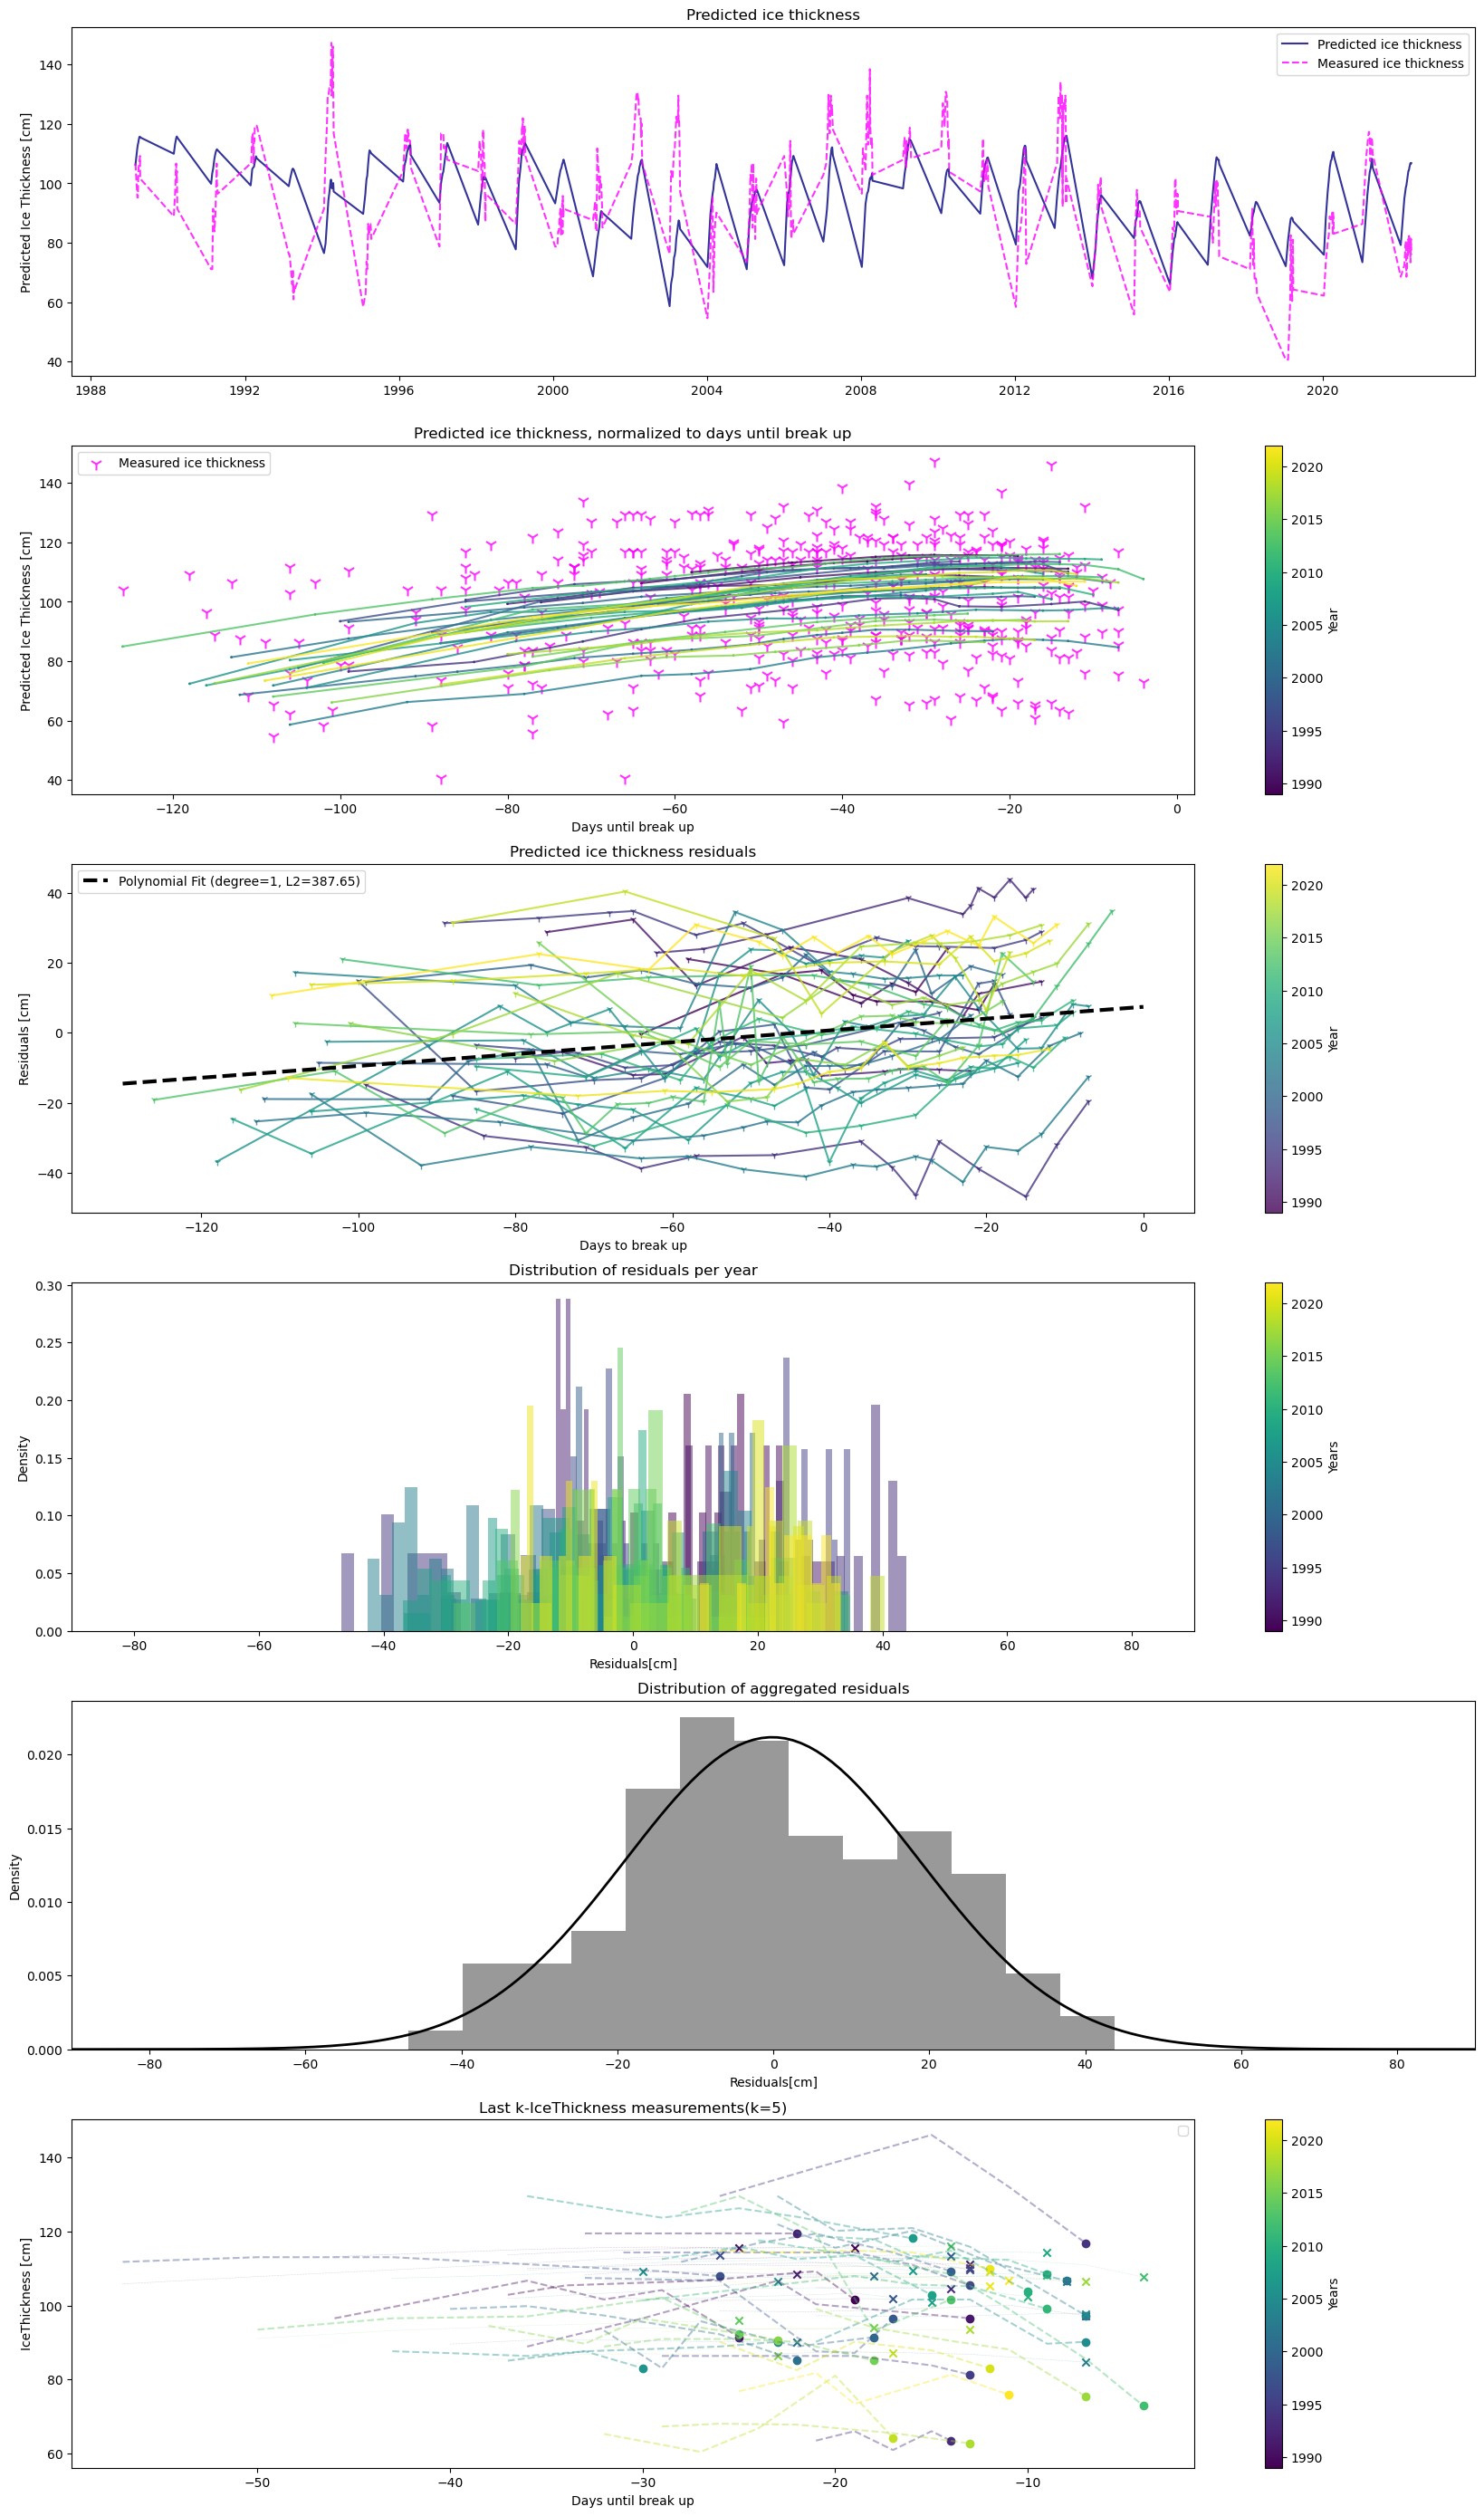

In [7]:
standard_plot(Data,Method_1_1)